In [1]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
import json
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


# Data aquiring

Data were aquired from [Tel-Aviv GIS](https://gisn.tel-aviv.gov.il/); 
- **Zoning plan no. 3616a** (Precinct 03) was selected
- Data were downloaded seperately for **_outside the White City Zone_** and **_inside the White City Zone_** (North and South to Arlozorov street). 
- _About **60%** of precinct 3 is **within the White City Zone.**_
- Within the plan's boundaries, the following layers were chosen and downloaded as _shapefiles_:
    - **Parcels** 
    - **Buildings** 
    - **Addresses**
    - **Historic Preservation**
    
    
- For each df, commercial streets were distinguished due to their different rezoning instructions.
- For each df, historic preservation designated buildings were excluded from the analysis (as the precinct's rezoning is not valid to them).

# TLV shapefiles
## Parcels precinct 3

In [158]:
# All precinct; in order to plot background for the city
parcelsshp = gpd.GeoDataFrame.from_file('data/all/parcelsshp/Parcels.shp')
parcelsshp = parcelsshp.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshp.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

parcelsshp.shape

(4560, 5)

In [159]:
# Inside White City Zone
parcelsshpIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Parcels.shp')
parcelsshpIN = parcelsshpIN.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshpIN.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

# creating BBL column (Block+Parcel)
parcelsshpIN['BBL'] = list(zip(parcelsshpIN.Block,parcelsshpIN.Parcel))
parcelsshpIN = parcelsshpIN.drop(['Block', 'Parcel'], axis=1)

parcelsshpIN.head()

,idParcel,ParcelArea,geometry,BBL
0,2079.0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)"
1,2081.0,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)"
2,2310.0,8.0,"POLYGON ((34.77327859883683 32.0863077792844, ...","(6902.0, 182.0)"
3,2311.0,12.0,"POLYGON ((34.77328772327471 32.08625947460223,...","(6902.0, 185.0)"
4,3208.0,281.0,"POLYGON ((34.77303315814694 32.08714497353659,...","(6902.0, 59.0)"


In [160]:
parcelsshpIN.shape

(2769, 4)

In [161]:
# Outside White City Zone
parcelsshpOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Parcels.shp')
parcelsshpOUT = parcelsshpOUT.drop(['dateimport', 'kstatushes'], axis=1)
parcelsshpOUT.columns = [['idParcel', 'Block', 'Parcel', 'ParcelArea', 'geometry']]

# creating BBL column (Block+Parcel)
parcelsshpOUT['BBL'] = list(zip(parcelsshpOUT.Block,parcelsshpOUT.Parcel))
parcelsshpOUT = parcelsshpOUT.drop(['Block', 'Parcel'], axis=1)

parcelsshpOUT.head()

,idParcel,ParcelArea,geometry,BBL
0,467.0,282.0,"POLYGON ((34.77856318885686 32.09408597755429,...","(6959.0, 32.0)"
1,469.0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)"
2,471.0,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)"
3,480.0,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)"
4,523.0,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)"


In [162]:
parcelsshpOUT.shape

(1911, 4)

## Buildings precinct 3

In [196]:
# Inside White City Zone

buildingsshpIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Buildings.shp')
buildingsshpIN = buildingsshpIN.drop(["shemmivne",'tamudim','dateimport', 'ShapeLengt', 'geometry'], axis = 1)
buildingsshpIN.columns = [['idConst', 'idBuilding', 'BuildingType', 'Floors', 'footprint', 'idBuildingOriginal', 'height']]
buildingsshpIN.head()

,idConst,idBuilding,BuildingType,Floors,footprint,idBuildingOriginal,height
0,21336.0,22826.0,מבנה בבנייה,4.0,351.225764,66222.0,16.0
1,21337.0,22827.0,מבנה רגיל,4.0,202.071150,66230.0,17.0
2,21338.0,22828.0,מבנה רגיל,4.0,392.806769,69687.0,18.0
3,21339.0,22829.0,מבנה רגיל,4.0,299.650683,65772.0,17.0
4,21340.0,22830.0,מבנה רגיל,3.0,310.687994,65783.0,18.0


In [197]:
buildingsshpIN.shape

(2563, 7)

In [198]:
# Outside White City Zone

buildingsshpOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Buildings.shp')
buildingsshpOUT = buildingsshpOUT.drop(["shemmivne",'tamudim','dateimport', 'ShapeLengt', 'geometry'], axis = 1)
buildingsshpOUT.columns = [['idConst', 'idBuilding', 'BuildingType', 'Floors', 'footprint', 'idBuildingOriginal', 'height']]
buildingsshpOUT.head()

,idConst,idBuilding,BuildingType,Floors,footprint,idBuildingOriginal,height
0,20915.0,22392.0,מבנה רגיל,4.0,123.433980,74178.0,15.0
1,20916.0,22394.0,מבנה רגיל,3.0,144.257155,79229.0,19.0
2,20917.0,22395.0,מבנה רגיל,1.0,69.271012,56945.0,22.0
3,20918.0,22396.0,מבנה רגיל,6.0,220.711618,55271.0,29.0
4,20919.0,22397.0,מבנה רגיל,6.0,267.161697,74812.0,23.0


In [199]:
buildingsshpOUT.shape

(1650, 7)

## Addresses precinct 3

In [200]:
# Inside White City Zone

AddressesIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Addresses.shp')
AddressesIN = AddressesIN.drop(["oidktovet",'krechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'dateimport', 'geometry'], axis = 1)
AddressesIN.columns = [['idAddress', 'oldidAddress', 'streetName', 'Address', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

# creating BBL column (Block+Parcel)
AddressesIN['BBL'] = list(zip(AddressesIN.Block,AddressesIN.Parcel))
AddressesIN = AddressesIN.drop(['Block', 'Parcel'], axis=1)

AddressesIN.head()

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75906.0,75906.0,הפרדס,הפרדס 9,179454.431532,665746.201281,34.780725,32.084308,"(6215.0, 294.0)"
1,74570.0,74570.0,בן גוריון,בן גוריון 59,178937.908125,665746.201281,34.775254,32.084291,"(6954.0, 98.0)"
2,69885.0,69885.0,רופין,רופין 45,178556.837843,665746.154375,34.771218,32.084277,"(6968.0, 68.0)"
3,73452.0,73452.0,שלמה המלך,שלמה המלך 93,179247.462858,665746.076311,34.778533,32.084300,"(6215.0, 202.0)"
4,76166.0,76166.0,באר טוביה,באר טוביה 24,179015.080046,665744.451250,34.776071,32.084278,"(6954.0, 89.0)"


In [201]:
AddressesIN.shape

(2863, 9)

In [202]:
# Outside White City Zone

AddressesOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Addresses.shp')
AddressesOUT = AddressesOUT.drop(["oidktovet",'krechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'dateimport', 'geometry'], axis = 1)
AddressesOUT.columns = [['idAddress', 'oldidAddress', 'streetName', 'Address', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

# creating BBL column (Block+Parcel)
AddressesOUT['BBL'] = list(zip(AddressesOUT.Block,AddressesOUT.Parcel))
AddressesOUT = AddressesOUT.drop(['Block', 'Parcel'], axis=1)

AddressesOUT.head()

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75400.0,75400.0,מיכה,מיכה 15,178988.400358,666805.232500,34.775744,32.093842,"(6961.0, 67.0)"
1,73105.0,73105.0,דיזנגוף,דיזנגוף 294,179091.845656,666804.826250,34.776840,32.093842,"(6959.0, 77.0)"
2,74069.0,74069.0,סוקולוב,סוקולוב 97,179242.033110,666803.560640,34.778431,32.093836,"(6959.0, 40.0)"
3,74897.0,74897.0,יחזקאל,יחזקאל 17,179178.251875,666803.263765,34.777756,32.093831,"(6959.0, 125.0)"
4,74710.0,74710.0,ישעיהו,ישעיהו 22,179330.033125,666801.732500,34.779363,32.093823,"(6957.0, 9.0)"


In [203]:
AddressesOUT.shape

(1878, 9)

## Historic Preservation designated buildings precinct 3

In [204]:
# Inside White City Zone

HistoricIN = gpd.GeoDataFrame.from_file('data/WhiteCity/Historical Buildings.shp')
HistoricIN = HistoricIN.drop(["OBJECTID",'shemmivne', 'swhistory', 'hagbalot','atraawarn', 'trhatraot', 'trmivnim'], axis = 1)

HistoricIN.head()

,thatraa,sttaba,ktovot,geometry
0,שימור - בינלאומי,2650ב,הירקון 118,"POLYGON ((34.76846874076895 32.08115666808349,..."
1,שימור - בינלאומי,2650ב,"בן יהודה 96 ,גורדון יהודה ליב 24","POLYGON ((34.77118473380646 32.08199703366387,..."
2,שימור - בינלאומי,2650ב,"הכרם 7 ,רופין 27","POLYGON ((34.77060031643551 32.08323174401378,..."
3,שימור - בינלאומי,2650ב,"בן גוריון 45 ,דיזנגוף 166","POLYGON ((34.77448150184389 32.08451973806656,..."
4,שימור - בינלאומי,2650ב,"בן גוריון 37 ,גרץ 1","POLYGON ((34.77351286195784 32.08477260898684,..."


In [205]:
HistoricIN.shape

(436, 4)

In [206]:
# Outside White City Zone

HistoricOUT = gpd.GeoDataFrame.from_file('data/noWhiteCity/Historical Buildings.shp')
HistoricOUT = HistoricOUT.drop(["OBJECTID",'shemmivne', 'swhistory', 'hagbalot','atraawarn', 'trhatraot', 'trmivnim'], axis = 1)

HistoricOUT.head()

,thatraa,sttaba,ktovot,geometry
0,שימור - בינלאומי,2650ב,"נורדאו 23 ,מיכה 2 ,מיכה 2א","POLYGON ((34.77573011759602 32.09261045347858,..."
1,שימור - בינלאומי,2650ב,נורדאו 15,"POLYGON ((34.77435722680622 32.0927583013431, ..."
2,שימור - בינלאומי,2650ב,נורדאו 9,"POLYGON ((34.77372277584232 32.09281543839031,..."
3,שימור - בינלאומי,2650ב,בן יהודה 201,"POLYGON ((34.77462431087153 32.09301221255826,..."
4,שימור - בינלאומי,2650ב,נחום הנביא 6,"POLYGON ((34.77429674374923 32.09310789846018,..."


In [207]:
HistoricOUT.shape

(45, 4)

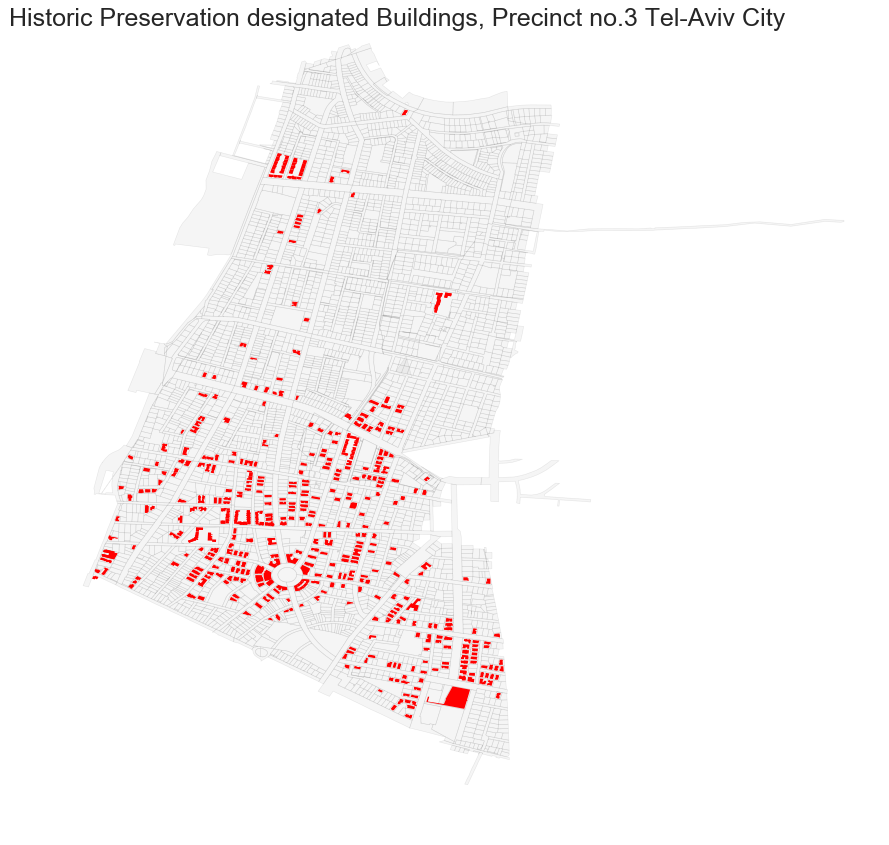

In [208]:
fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='grey', edgecolor='k',linewidth=.6, alpha=0.08)
HistoricOUT.plot(ax=ax, color='red', edgecolor=None);
HistoricIN.plot(ax=ax, color='red', edgecolor=None);
plt.title('Historic Preservation designated Buildings, Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

## Joining Addresses + Historic preservation in order to remove historic buildings

In [209]:
AddressesIN = AddressesIN.merge(HistoricIN, left_on = 'Address', right_on = 'ktovot', how='left').fillna(0)
AddressesIN = AddressesIN[AddressesIN['thatraa'] == 0]
AddressesIN = AddressesIN.drop(['thatraa', 'sttaba', 'ktovot','geometry'], axis=1)
AddressesIN.shape

(2600, 9)

In [210]:
AddressesIN.head(3)

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75906.0,75906.0,הפרדס,הפרדס 9,179454.431532,665746.201281,34.780725,32.084308,"(6215.0, 294.0)"
1,74570.0,74570.0,בן גוריון,בן גוריון 59,178937.908125,665746.201281,34.775254,32.084291,"(6954.0, 98.0)"
2,69885.0,69885.0,רופין,רופין 45,178556.837843,665746.154375,34.771218,32.084277,"(6968.0, 68.0)"


In [211]:
AddressesOUT = AddressesOUT.merge(HistoricOUT, left_on = 'Address', right_on = 'ktovot', how='left').fillna(0)
AddressesOUT = AddressesOUT[AddressesOUT['thatraa'] == 0]
AddressesOUT = AddressesOUT.drop(['thatraa', 'sttaba', 'ktovot','geometry'], axis=1)
AddressesOUT.shape

(1849, 9)

In [212]:
AddressesOUT.head(3)

,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat,BBL
0,75400.0,75400.0,מיכה,מיכה 15,178988.400358,666805.23250,34.775744,32.093842,"(6961.0, 67.0)"
1,73105.0,73105.0,דיזנגוף,דיזנגוף 294,179091.845656,666804.82625,34.776840,32.093842,"(6959.0, 77.0)"
2,74069.0,74069.0,סוקולוב,סוקולוב 97,179242.033110,666803.56064,34.778431,32.093836,"(6959.0, 40.0)"


# Joining shp to have Buildings + Parcels data for each observation
### White City Zone

In [213]:
PCT3shpIN = parcelsshpIN.merge(AddressesIN, on = 'BBL')
PCT3shpIN.head()

,idParcel,ParcelArea,geometry,BBL,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat
0,2079.0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",76317.0,76317.0,ברנשטיין אדוארד,ברנשטיין אדוארד 26,178681.048750,666071.357485,34.772520,32.087214
1,2081.0,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)",73537.0,73537.0,ארלוזורוב,ארלוזורוב 16,178763.595656,666063.263750,34.773394,32.087144
2,2081.0,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)",65865.0,65865.0,בן יהודה,בן יהודה 172,178753.814406,666062.545031,34.773291,32.087137
3,3208.0,281.0,"POLYGON ((34.77303315814694 32.08714497353659,...","(6902.0, 59.0)",65834.0,65834.0,בן יהודה,בן יהודה 141,178721.853437,666058.482546,34.772952,32.087099
4,3209.0,518.0,"POLYGON ((34.77120851853805 32.08690002717208,...","(6966.0, 20.0)",66281.0,66281.0,הירקון,הירקון 186,178553.064406,666058.013765,34.771164,32.087089


In [214]:
PCT3shpIN.shape

(2600, 12)

In [216]:
PCT3shpIN = PCT3shpIN.merge(buildingsshpIN, right_on = 'idBuildingOriginal', left_on = 'idAddress')
PCT3shpIN = PCT3shpIN.drop(['idConst', 'idBuilding','idAddress', 'Address', 'oldidAddress', 'idParcel', 'idBuildingOriginal'], axis = 1)

PCT3shpIN.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,BuildingType,Floors,footprint,height
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",ברנשטיין אדוארד,178681.048750,666071.357485,34.772520,32.087214,מבנה רגיל,3.0,154.417758,17.0
1,284.0,"POLYGON ((34.77344341891495 32.08711095658551,...","(6902.0, 116.0)",בן יהודה,178753.814406,666062.545031,34.773291,32.087137,מבנה רגיל,5.0,144.052006,22.0
2,281.0,"POLYGON ((34.77303315814694 32.08714497353659,...","(6902.0, 59.0)",בן יהודה,178721.853437,666058.482546,34.772952,32.087099,מבנה רגיל,5.0,158.177808,22.0
3,518.0,"POLYGON ((34.77120851853805 32.08690002717208,...","(6966.0, 20.0)",הירקון,178553.064406,666058.013765,34.771164,32.087089,מבנה רגיל,4.0,247.139010,18.0
4,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",השופטים,179488.994062,664838.560656,34.781129,32.076125,מבנה רגיל,4.0,252.530801,16.0


In [217]:
PCT3shpIN.shape

(1642, 12)

In [218]:
type(PCT3shpIN)

geopandas.geodataframe.GeoDataFrame

### outside White City Zone

In [219]:
PCT3shpOUT = parcelsshpOUT.merge(AddressesOUT, on = 'BBL')
PCT3shpOUT.head()

,idParcel,ParcelArea,geometry,BBL,idAddress,oldidAddress,streetName,Address,AddressX,AddressY,lon,lat
0,467.0,282.0,"POLYGON ((34.77856318885686 32.09408597755429,...","(6959.0, 32.0)",74071.0,74071.0,סוקולוב,סוקולוב 101,179249.556608,666838.013735,34.778509,32.094147
1,469.0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",74701.0,74701.0,ישעיהו,ישעיהו 12,179300.251875,666835.216860,34.779047,32.094123
2,471.0,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",75404.0,75404.0,מיכה,מיכה 19,178975.822157,666836.638796,34.775610,32.094125
3,480.0,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",74955.0,74955.0,מלאכי,מלאכי 14,179141.806578,666693.248156,34.777374,32.092838
4,523.0,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)",74760.0,74760.0,יוחנן הורקנוס,יוחנן הורקנוס 11,179451.892531,666819.029375,34.780654,32.093983


In [220]:
PCT3shpOUT.shape

(1849, 12)

In [221]:
PCT3shpOUT = PCT3shpOUT.merge(buildingsshpOUT, right_on = 'idBuildingOriginal', left_on = 'idAddress')
PCT3shpOUT = PCT3shpOUT.drop(['idConst', 'idBuilding','idAddress', 'Address','oldidAddress', 'idParcel', 'idBuildingOriginal'], axis = 1)

PCT3shpOUT.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,BuildingType,Floors,footprint,height
0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",ישעיהו,179300.251875,666835.216860,34.779047,32.094123,מבנה רגיל,4.0,117.242392,13.0
1,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",מיכה,178975.822157,666836.638796,34.775610,32.094125,מבנה רגיל,4.0,208.665958,18.0
2,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",מלאכי,179141.806578,666693.248156,34.777374,32.092838,מבנה רגיל,4.0,155.031697,17.0
3,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)",יוחנן הורקנוס,179451.892531,666819.029375,34.780654,32.093983,מבנה רגיל,3.0,303.026016,13.0
4,533.0,"POLYGON ((34.7804767984501 32.09392660250479, ...","(6958.0, 123.0)",יוחנן הורקנוס,179434.376860,666817.998110,34.780468,32.093973,מבנה רגיל,4.0,276.398086,22.0


In [222]:
PCT3shpOUT.shape

(1176, 12)

In [223]:
type(PCT3shpOUT)

geopandas.geodataframe.GeoDataFrame

# Data cleaning and munging
### White City Zone

In [224]:
# dropping buildings that are not 2-4 floors, assuming the rezoning is not valid to them
PCT3shpIN = (PCT3shpIN[PCT3shpIN['Floors'] <= 4.0])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['Floors'] >= 3.0])

# dropping non-residential buildings
PCT3shpIN = (PCT3shpIN[PCT3shpIN['BuildingType'] == 'מבנה רגיל']).reset_index()
PCT3shpIN = PCT3shpIN.drop(['index', 'BuildingType'], axis=1)

# dropping area > 1250 m2
PCT3shpIN = (PCT3shpIN[PCT3shpIN['ParcelArea'] <= 1250])


# Calculating Floor Area (Floors * ShapeArea)
PCT3shpIN['FloorArea'] = PCT3shpIN['Floors'] * PCT3shpIN['footprint']
# Calculating Floor-Area Ratio (FAR) (FA / ParcelArea)
PCT3shpIN['FAR'] = PCT3shpIN['FloorArea'] / PCT3shpIN['ParcelArea']
#PCT3shpIN = (PCT3shpIN[PCT3shpIN['FAR'] <= 3])

PCT3shpIN.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",ברנשטיין אדוארד,178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705
1,518.0,"POLYGON ((34.77120851853805 32.08690002717208,...","(6966.0, 20.0)",הירקון,178553.064406,666058.013765,34.771164,32.087089,4.0,247.139010,18.0,988.556038,1.908409
2,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",השופטים,179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220
3,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",פינסקר,178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913
4,360.0,"POLYGON ((34.77120676544948 32.07850701386839,...","(6906.0, 81.0)",שלום עליכם,178535.861235,665120.513781,34.771022,32.078635,4.0,150.359237,19.0,601.436948,1.670658


In [225]:
PCT3shpIN.shape

(1310, 13)

### outside White City Zone

In [226]:
# dropping buildings that are not 2-4 floors, assuming the rezoning is not valid to them
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['Floors'] <= 4.0])
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['Floors'] >= 3.0])

# dropping non-residential buildings
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['BuildingType'] == 'מבנה רגיל']).reset_index()
PCT3shpOUT = PCT3shpOUT.drop(['index', 'BuildingType'], axis=1)

# dropping area > 1250 m2
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['ParcelArea'] <= 1250])


# Calculating Floor Area (Floors * ShapeArea)
PCT3shpOUT['FloorArea'] = PCT3shpOUT['Floors'] * PCT3shpOUT['footprint']
# Calculating Floor-Area Ratio (FAR) (FA / ParcelArea)
PCT3shpOUT['FAR'] = PCT3shpOUT['FloorArea'] / PCT3shpOUT['ParcelArea']
#PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['FAR'] <= 3])

PCT3shpOUT.head()

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",ישעיהו,179300.251875,666835.216860,34.779047,32.094123,4.0,117.242392,13.0,468.969568,1.705344
1,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",מיכה,178975.822157,666836.638796,34.775610,32.094125,4.0,208.665958,18.0,834.663832,2.001592
2,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",מלאכי,179141.806578,666693.248156,34.777374,32.092838,4.0,155.031697,17.0,620.126790,1.908082
3,553.0,"POLYGON ((34.78063465594656 32.09392296441273,...","(6958.0, 34.0)",יוחנן הורקנוס,179451.892531,666819.029375,34.780654,32.093983,3.0,303.026016,13.0,909.078048,1.643902
4,533.0,"POLYGON ((34.7804767984501 32.09392660250479, ...","(6958.0, 123.0)",יוחנן הורקנוס,179434.376860,666817.998110,34.780468,32.093973,4.0,276.398086,22.0,1105.592344,2.074282


In [227]:
PCT3shpOUT.shape

(862, 13)

In [229]:
PCT3shp = [PCT3shpIN, PCT3shpOUT]
PCT3shp = pd.concat(PCT3shp)
PCT3shp.shape

(2172, 13)

In [230]:
type(PCT3shp)

geopandas.geodataframe.GeoDataFrame

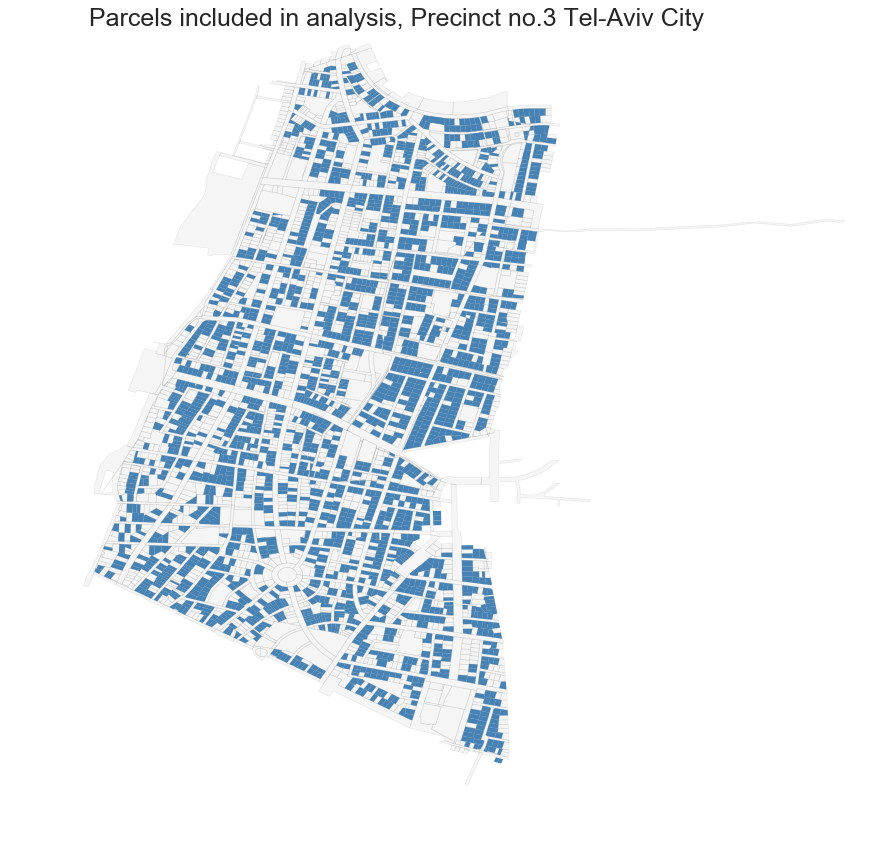

In [323]:
fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='grey', edgecolor='k',linewidth=.6, alpha=0.08)
PCT3shp.plot(ax=ax, color='steelBlue', edgecolor=None);
plt.title('Parcels included in analysis, Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

-----

# FAR distribution precinct 3 -- current

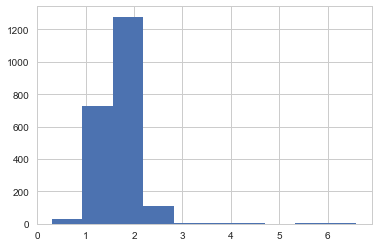

In [232]:
PCT3shp['FAR'].hist()
# plot the cumulative function
#plt.plot(, cumulative, c='blue')

In [235]:
PCT3shp[PCT3shp['FAR'] > 5]

,ParcelArea,geometry,BBL,streetName,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
84,236.0,"POLYGON ((34.77908895419139 32.08480466091939,...","(6215.0, 310.0)",שלמה המלך,179290.126875,665786.716875,34.778983,32.084668,4.0,318.858258,14.0,1275.433034,5.404377
1205,174.0,"POLYGON ((34.76863153797451 32.08071902294814,...","(6968.0, 217.0)",הירקון,178304.486281,665367.232515,34.768561,32.080852,3.0,382.338068,13.0,1147.014205,6.592036
295,131.0,"POLYGON ((34.77392052120216 32.09143238420705,...","(6960.0, 36.0)",ויתקין,178800.126875,666536.279375,34.773761,32.091411,3.0,230.797483,12.0,692.392449,5.285439
396,178.0,"POLYGON ((34.77974613025233 32.08718018667274,...","(6214.0, 272.0)",יהושע בן נון,179355.212812,666057.888796,34.779661,32.087116,4.0,244.819094,14.0,979.276378,5.501553
663,205.0,"POLYGON ((34.78261836896628 32.09456747160394,...","(6212.0, 451.0)",שמעון התרסי,179628.009703,666892.716875,34.782516,32.094653,4.0,312.777067,15.0,1251.108270,6.102967
741,187.0,"POLYGON ((34.78211511646004 32.09475902956023,...","(6958.0, 89.0)",שמעון התרסי,179586.619078,666911.388781,34.782077,32.094820,4.0,256.593567,18.0,1026.374270,5.488632


# Plot a map of Floor Area for precinct 3

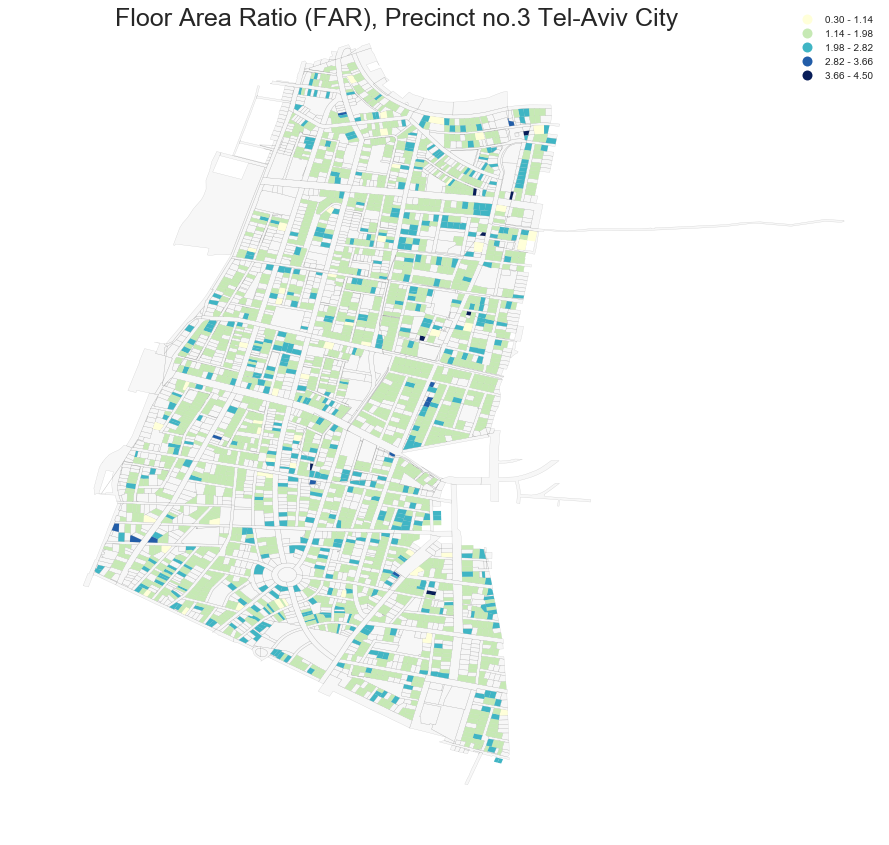

In [326]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")
# vmin, vmax = 0, 4

# cax = fig.add_axes([0.1, 0.80, .18, 0.015])
# sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# fig.colorbar(sm, cax=cax, orientation='horizontal')

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.3, alpha=0.18)
PCT3shp[PCT3shp['FAR'] <= 5] .plot(ax=ax, column='FAR', cmap='YlGnBu', scheme='Equal_Interval', legend=True);
plt.title('Floor Area Ratio (FAR), Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

## Defining commercial streets 
- Inside White City Zone: **Dizengof, Ben-Yehuda, Arlozorov, Hayarkon** streets
- Outside White City Zone: **Dizengof, Ben-Yehuda** streets

In [239]:
commerceIN = [PCT3shpIN[PCT3shpIN['streetName']  == 'דיזנגוף'], PCT3shpIN[PCT3shpIN['streetName']  == 'בן יהודה'], 
              PCT3shpIN[PCT3shpIN['streetName']  == 'ארלוזורוב'], PCT3shpIN[PCT3shpIN['streetName']  == 'הירקון']]
commerceIN = pd.concat(commerceIN).reset_index()
commerceIN = commerceIN.drop(['index', 'streetName'], axis=1)

commerceIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
0,306.0,"POLYGON ((34.77406439592887 32.08376795464817,...","(7078.0, 116.0)",178816.173765,665691.591844,34.773967,32.083794,3.0,134.125293,15.0,402.375878,1.314954
1,434.0,"POLYGON ((34.77371048563466 32.08158037063139,...","(7113.0, 55.0)",178775.923750,665441.716936,34.773551,32.081539,3.0,222.888763,18.0,668.666289,1.540706
2,554.0,"POLYGON ((34.77452953052502 32.08566399724136,...","(6902.0, 158.0)",178863.126875,665903.669985,34.774455,32.085708,3.0,309.996586,13.0,929.989758,1.678682


In [240]:
commerceIN.shape

(157, 12)

In [241]:
commerceOUT = [PCT3shpOUT[PCT3shpOUT['streetName']  == 'דיזנגוף'], PCT3shpOUT[PCT3shpOUT['streetName']  == 'בן יהודה']]
commerceOUT = pd.concat(commerceOUT).reset_index()
commerceOUT = commerceOUT.drop(['index', 'streetName'], axis=1)

commerceOUT.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
0,283.0,"POLYGON ((34.77626542263859 32.0959676525227, ...","(6963.0, 9.0)",179038.103437,667047.076281,34.776261,32.096025,4.0,133.578753,20.0,534.315012,1.888039
1,458.0,"POLYGON ((34.77638620981109 32.09411838256487,...","(6961.0, 58.0)",179066.931547,666844.326250,34.776575,32.094198,3.0,220.570635,17.0,661.711904,1.444786
2,350.0,"POLYGON ((34.77709255079024 32.09395967222037,...","(6959.0, 76.0)",179094.392500,666821.373140,34.776866,32.093992,3.0,157.218641,16.0,471.655924,1.347588


In [242]:
commerceOUT.shape

(76, 12)

In [243]:
# dropping commerce from PCT3IN 

PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'דיזנגוף'])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'בן יהודה']) 
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'ארלוזורוב'])
PCT3shpIN = (PCT3shpIN[PCT3shpIN['streetName']  != 'הירקון']).reset_index()

PCT3shpIN = PCT3shpIN.drop(['index', 'streetName'], axis=1)
PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913


In [244]:
PCT3shpIN.shape

(1153, 12)

In [245]:
# dropping commerce from PCT3OUT

PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['streetName']  != 'דיזנגוף'])
PCT3shpOUT = (PCT3shpOUT[PCT3shpOUT['streetName']  != 'בן יהודה']).reset_index()

PCT3shpOUT = PCT3shpOUT.drop(['index', 'streetName'], axis=1)
PCT3shpOUT.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR
0,275.0,"POLYGON ((34.77912810593715 32.09412141266468,...","(6957.0, 5.0)",179300.251875,666835.216860,34.779047,32.094123,4.0,117.242392,13.0,468.969568,1.705344
1,417.0,"POLYGON ((34.77570836899265 32.0941418815794, ...","(6961.0, 106.0)",178975.822157,666836.638796,34.775610,32.094125,4.0,208.665958,18.0,834.663832,2.001592
2,325.0,"POLYGON ((34.77745222818285 32.09287050036341,...","(6959.0, 108.0)",179141.806578,666693.248156,34.777374,32.092838,4.0,155.031697,17.0,620.126790,1.908082


In [246]:
PCT3shpOUT.shape

(786, 12)


# _Download data separate for the white city and outside of it

1. Parcels, Buildings, Addresses for north and south of Arlozorov st.
    (historic)
    (dangerous)
2. Calculations - current
3. Calculations - rezoning
-----

In [247]:
# white city zone
whitecity = gpd.GeoDataFrame.from_file('data/all/whitecity/White City Zone.shp')
#whitecity = whitecity.drop(["oidktovet",'krechov','trechov', 'msbayit', 'knisa','kstatushes', 'tbayitvekn', 'tktovetmel', 'dateimport', 'geometry'], axis = 1)
#whitecity.columns = [['idAddress', 'oldidAddress', 'AddressX','AddressY','Block', 'Parcel', 'lon', 'lat']]

whitecity.head()
# historic preservation

,oidezor,shemezor,tezor,kezor,dateimport,geometry
0,1.0,BUFFER,אזור חייץ הכרזה,4.0,17/01/2013 02:12:19,"POLYGON ((34.77010483312776 32.08548408809591,..."
1,2.0,ZONE A,אזור ההכרזה,1.0,17/01/2013 02:12:19,"POLYGON ((34.77053337341343 32.08536861271146,..."
2,3.0,BUFFER,אזור חייץ הכרזה,4.0,17/01/2013 02:12:19,"POLYGON ((34.77010483312776 32.08548408809591,..."
3,4.0,ZONE A,אזור ההכרזה,1.0,17/01/2013 02:12:19,"POLYGON ((34.77053337341343 32.08536861271146,..."
4,5.0,BUFFER,אזור חייץ הכרזה,4.0,17/01/2013 02:12:19,"POLYGON ((34.77063964786722 32.07718216118067,..."


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


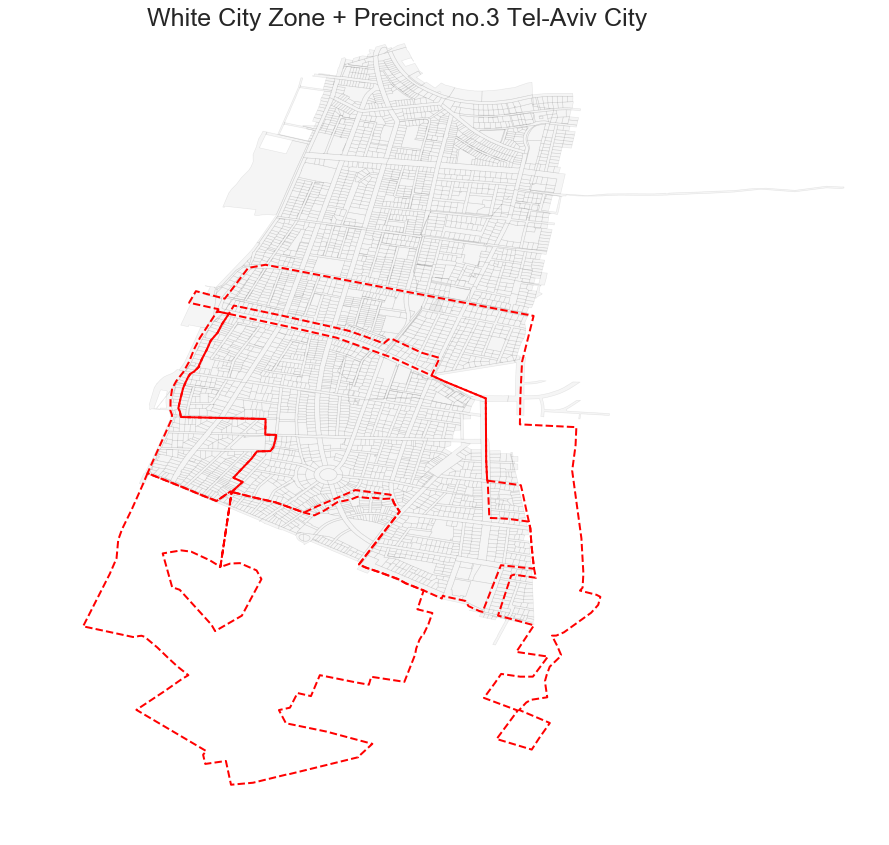

In [349]:
fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='grey', edgecolor='k',linewidth=.6, alpha=0.08)
whitecity[whitecity['oidezor'] == 4.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');
whitecity[whitecity['oidezor'] == 3.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');
whitecity[whitecity['oidezor'] == 1.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');
whitecity[whitecity['oidezor'] == 5.0].plot(ax=ax, color='none', edgecolor='red',linestyle='dashed', linewidth=2, label='White City Zone');

pl.legend()
pl.title('White City Zone + Precinct no.3 Tel-Aviv City', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

------
# Calculating new rezoning parameters: anticipated FA,  anticipated FAR, Floors

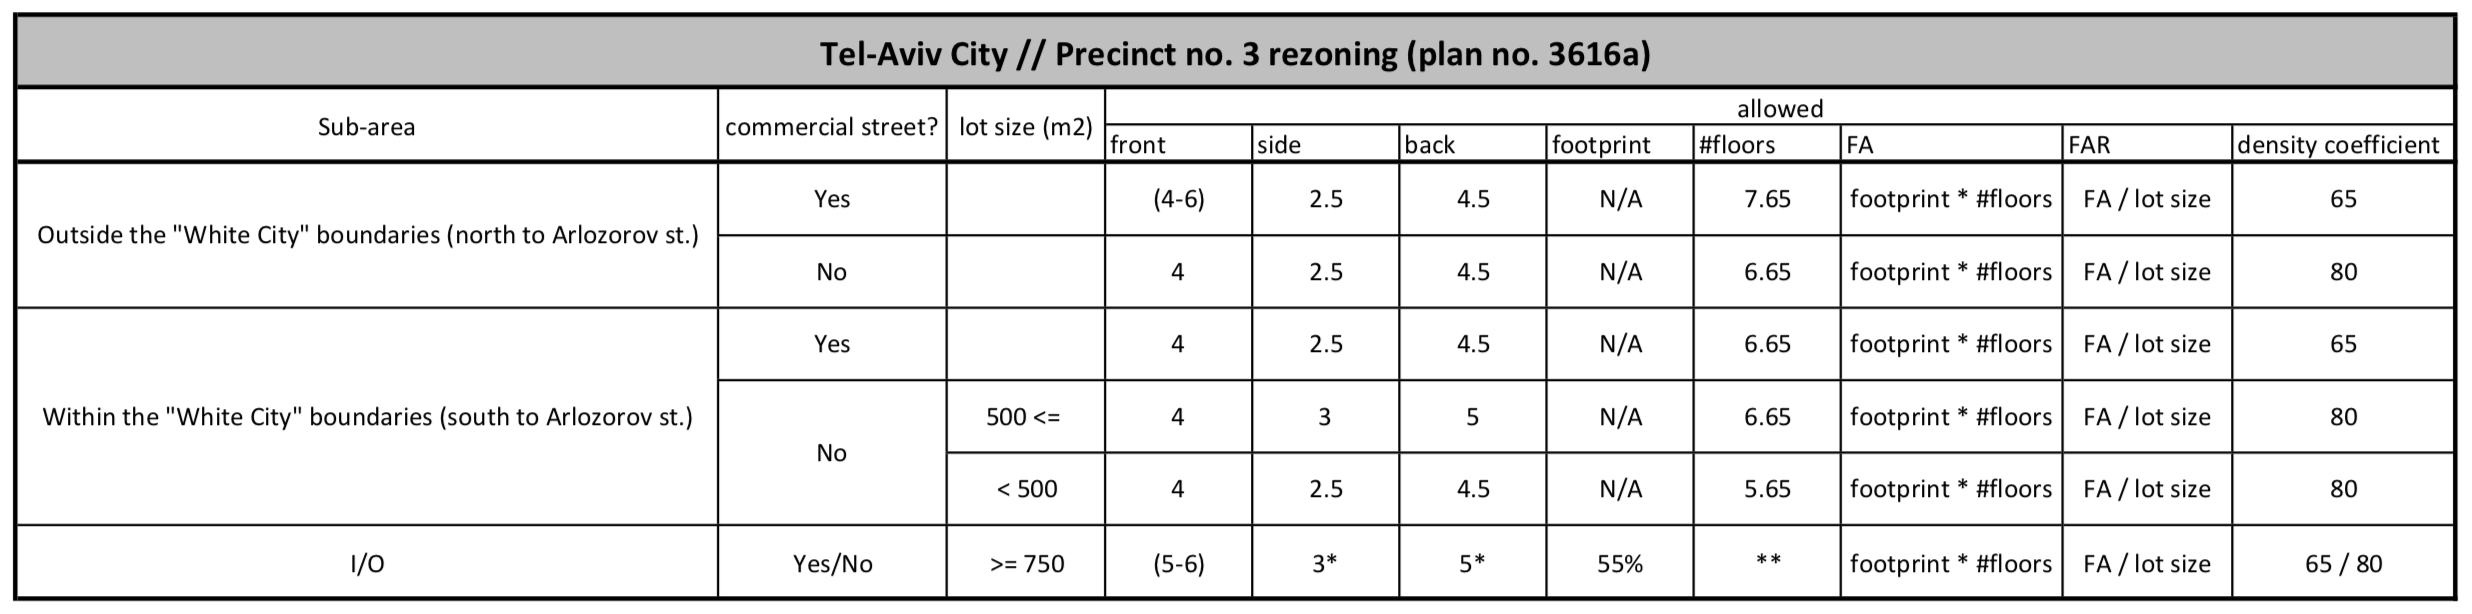

In [249]:
# Rezoning Precinct3 table

from IPython.display import Image
Image('precinct3rezoning.png')

### Fig.1 Precinct no. 3 rezoning guidlines
Outside the **"White City"** zone ....
Inside the **"White City"** zone ....

In [250]:
import random
random.seed(777)

In [251]:
# creating random footprint for further calculation >> assuming footprint between 42% - 55%

PCT3shpIN['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(PCT3shpIN))
PCT3shpOUT['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(PCT3shpOUT))
commerceIN['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(commerceIN))
commerceOUT['randFootprint'] = np.random.uniform(0.42, 0.55, size = len(commerceOUT))

PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,randFootprint
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,0.480472
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,0.451099
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,0.504862


In [252]:
# new footprint (random between 0.4 and 0.55 footprint for small parcels)
PCT3shpIN['footprint_new'] = np.where(PCT3shpIN['ParcelArea'] >= 750, PCT3shpIN['ParcelArea'] * 0.55,
                                      PCT3shpIN['ParcelArea'] * PCT3shpIN['randFootprint'])
PCT3shpOUT['footprint_new'] = np.where(PCT3shpOUT['ParcelArea'] >= 750, PCT3shpOUT['ParcelArea'] * 0.55,
                                       PCT3shpOUT['ParcelArea'] * PCT3shpOUT['randFootprint'])
commerceIN['footprint_new'] = np.where(commerceIN['ParcelArea'] >= 750, commerceIN['ParcelArea'] * 0.55, 
                                       commerceIN['ParcelArea'] * commerceIN['randFootprint'])
commerceOUT['footprint_new'] = np.where(commerceOUT['ParcelArea'] >= 750, commerceOUT['ParcelArea'] * 0.55, 
                                        commerceOUT['ParcelArea'] * commerceOUT['randFootprint'])

# new no. of floors 
PCT3shpIN['Floors_new'] = np.where(PCT3shpIN['ParcelArea'] < 500, 5.65, 6.65)
PCT3shpOUT['Floors_new'] = 6.65
commerceIN['Floors_new'] = 6.65
commerceOUT['Floors_new'] = 7.65

PCT3shpIN.head(3)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,randFootprint,footprint_new,Floors_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",178681.048750,666071.357485,34.772520,32.087214,3.0,154.417758,17.0,463.253274,1.690705,0.480472,131.649351,5.65
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",179488.994062,664838.560656,34.781129,32.076125,4.0,252.530801,16.0,1010.123204,1.965220,0.451099,231.864965,6.65
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",178653.783140,664841.779406,34.772283,32.076125,4.0,171.562549,14.0,686.250196,1.994913,0.504862,173.672458,5.65


In [253]:
commerceOUT.head(2)

,ParcelArea,geometry,BBL,AddressX,AddressY,lon,lat,Floors,footprint,height,FloorArea,FAR,randFootprint,footprint_new,Floors_new
0,283.0,"POLYGON ((34.77626542263859 32.0959676525227, ...","(6963.0, 9.0)",179038.103437,667047.076281,34.776261,32.096025,4.0,133.578753,20.0,534.315012,1.888039,0.549713,155.568762,7.65
1,458.0,"POLYGON ((34.77638620981109 32.09411838256487,...","(6961.0, 58.0)",179066.931547,666844.326250,34.776575,32.094198,3.0,220.570635,17.0,661.711904,1.444786,0.512577,234.760410,7.65


## Concat all df 

In [254]:
PCT3all = [PCT3shpIN, PCT3shpOUT, commerceIN, commerceOUT]
PCT3shp = pd.concat(PCT3all)
PCT3shp = PCT3shp.drop(['AddressX', 'AddressY', 'lon', 'lat', 'randFootprint'], axis=1)
PCT3shp.head()

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,footprint_new,Floors_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,131.649351,5.65
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,231.864965,6.65
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,173.672458,5.65
3,360.0,"POLYGON ((34.77120676544948 32.07850701386839,...","(6906.0, 81.0)",4.0,150.359237,19.0,601.436948,1.670658,153.047991,5.65
4,339.0,"POLYGON ((34.77061162187506 32.07857072714503,...","(6906.0, 92.0)",3.0,168.250159,16.0,504.750477,1.488939,143.990602,5.65


In [255]:
PCT3shp.shape

(2172, 10)

In [256]:
# anticipated floorarea 
PCT3shp['FA_new'] = PCT3shp['footprint_new'] * PCT3shp['Floors_new']

# anticipated FAR 
PCT3shp['FAR_new'] = PCT3shp['FA_new'] / PCT3shp['ParcelArea']
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,footprint_new,Floors_new,FA_new,FAR_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,131.649351,5.65,743.818831,2.714667
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,231.864965,6.65,1541.902014,2.999809
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,173.672458,5.65,981.249388,2.852469


# FAR distribution precinct 3 -- all rezoning utilized

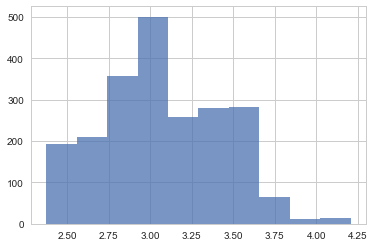

In [330]:
#PCT3shp['FAR'].hist(alpha=0.75)
PCT3shp['FAR_new'].hist(alpha=0.75)

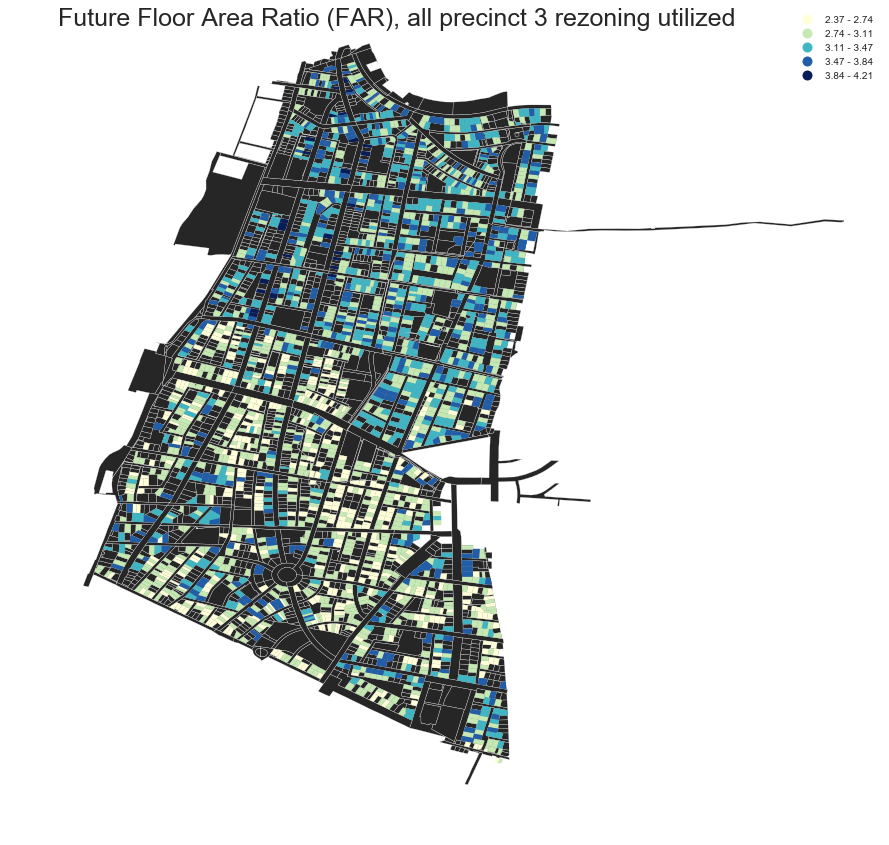

In [328]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='k', edgecolor='w',linewidth=.3, alpha=0.85)
PCT3shp.plot(ax=ax, column='FAR_new', cmap='YlGnBu', scheme='Equal_Interval', legend=True);
plt.title('Future Floor Area Ratio (FAR), all precinct 3 rezoning utilized', size=25, y=.97, x=0.42)
tmp = ax.axis('off')

# Calculating current land value,  assessed cost for demolishment + new construction, and Feasibility

## _1. Land Value (current)_
Land value was assessed using **Tax appraisal** as a proxy. Tel-Aviv City Tax appraisal, year 2018 document is the base of this calculation.

According to the document and the areas + properties of the buildings defined in it, this analysis assumes that all the buildings that are included in are in **tax appraisal area 2** and that they are defined as **type E or F**. This means the appraisal is **39.15 Israeli Shekels per m2** (~12$/m2).

For the new buildings, this analysis assumes the buildings to be defined defined as **type N (new)**. This means the appraisal will be **70.35 Israeli Shekels per m2** (~20$/m2).

In [281]:
# Calculating current Land Value (floorArea * 39.15)
PCT3shp['landValue'] = PCT3shp['FloorArea'] * 39.15

# Calculating future Land Value (FA_new * 70.35)
PCT3shp['landValue_new'] = PCT3shp['FA_new'] * 70.35

PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,footprint_new,Floors_new,FA_new,FAR_new,landValue,landValue_new
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,131.649351,5.65,743.818831,2.714667,18136.365677,52327.654746
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,231.864965,6.65,1541.902014,2.999809,39546.323437,108472.806720
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,173.672458,5.65,981.249388,2.852469,26866.695173,69030.894479


## _2. Demolishment + construction costs_
Talking with Israeli developers, and being precinct 3 a relatively small area with the assumed equal demand for housing, the cost (shekels/m2) of demolishment is **800 Israeli shekels per m2**:

```python
PCT3shp['demolishCost'] = PCT3shp['FloorArea'] * 800
```

The cost of construction in the precinct was assessed as **7,500 Israeli shekels per m2**:

```python
PCT3shp['costCost'] = PCT3shp['FA_new'] * 7500
```

Additional cost will be due to the constraction of the **basement**, which is **85%** of the parcel's area and mostly contains **2 floors**, and aseessed in the cost of **3,500 Israeli shekels per m2**:

```python
PCT3shp['basementCost'] = PCT3shp['FloorArea'] * 0.85 * 2 * 2500
```

In [339]:
PCT3shp['consCosts-K'] = (PCT3shp['FA_new'] * 8)

#PCT3shp['consCosts-K'] = (PCT3shp['FloorArea'] * 0.8 + PCT3shp['FA_new'] * 7.5 + PCT3shp['FloorArea'] * 0.85 * 2 * 2.5)
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,footprint_new,Floors_new,FA_new,FAR_new,landValue,landValue_new,consCosts-K
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,131.649351,5.65,743.818831,2.714667,18136.365677,52327.654746,5950.550646
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,231.864965,6.65,1541.902014,2.999809,39546.323437,108472.806720,12335.216116
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,173.672458,5.65,981.249388,2.852469,26866.695173,69030.894479,7849.995108


## _3. Feasibility_

Feasibility was ddefined by having less than 30% land value / land value_new >> **DANA CHECK, TBD!!**

In [384]:
PCT3shp[(PCT3shp['landValue'] / PCT3shp['landValue_new']) < 0.3]

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,footprint_new,Floors_new,FA_new,FAR_new,landValue,landValue_new,consCosts-K,test
10,512.0,"POLYGON ((34.7795689506059 32.08369031032901, ...","(6953.0, 26.0)",3.0,262.545771,18.0,787.637314,1.538354,247.210764,6.65,1643.951584,3.210843,30836.000863,115651.993926,13151.612671,0.266627
11,504.0,"POLYGON ((34.777780521537 32.08214821565038, 3...","(6215.0, 91.0)",3.0,242.516606,12.0,727.549819,1.443551,239.549305,6.65,1593.002878,3.160720,28483.575433,112067.752441,12744.023021,0.254164
21,549.0,"POLYGON ((34.77918802039485 32.08134402596501,...","(6215.0, 450.0)",3.0,278.286030,13.0,834.858090,1.520689,297.851211,6.65,1980.710555,3.607852,32684.694224,139342.987544,15845.684440,0.234563
22,428.0,"POLYGON ((34.77665376138459 32.0812172717301, ...","(6903.0, 39.0)",3.0,195.847564,16.0,587.542692,1.372763,221.834665,5.65,1253.365855,2.928425,23002.296392,88174.287918,10026.926842,0.260873
23,642.0,"POLYGON ((34.77543536537172 32.08108864302828,...","(7113.0, 107.0)",3.0,291.219648,18.0,873.658944,1.360839,330.764544,6.65,2199.584216,3.426144,34203.747658,154740.749602,17596.673729,0.221039
28,440.0,"POLYGON ((34.77723039846446 32.07379336703409,...","(6904.0, 40.0)",3.0,206.826521,17.0,620.479563,1.410181,235.338067,5.65,1329.660079,3.021955,24291.774891,93541.586553,10637.280631,0.259690
31,438.0,"POLYGON ((34.77335363504446 32.0820585379203, ...","(7078.0, 85.0)",3.0,193.542069,16.0,580.626207,1.325631,220.683078,5.65,1246.859391,2.846711,22731.516004,87716.558180,9974.875131,0.259147
32,504.0,"POLYGON ((34.77274719779709 32.08145787645159,...","(7113.0, 39.0)",3.0,250.102256,15.0,750.306767,1.488704,264.676204,6.65,1760.096757,3.492255,29374.509909,123822.806845,14080.774055,0.237230
37,458.0,"POLYGON ((34.77236295410738 32.08721538282639,...","(6902.0, 32.0)",3.0,215.441532,12.0,646.324596,1.411189,247.208049,5.65,1396.725475,3.049619,25303.607933,98259.637190,11173.803803,0.257518
39,530.0,"POLYGON ((34.77408664149605 32.08666321482214,...","(6902.0, 142.0)",3.0,259.500470,11.0,778.501409,1.468871,241.596695,6.65,1606.618021,3.031355,30478.330143,113025.577802,12852.944171,0.269659


In [393]:
PCT3shp['test'] = PCT3shp['landValue'] / PCT3shp['landValue_new']
PCT3shp['Feasible'] = np.where(PCT3shp['test'] < 0.3, 0, 1)
PCT3shp['Feasible'].value_counts()
#PCT3shp.shape

1    1289
0     883
Name: Feasible, dtype: int64

In [395]:
PCT3shp.head(3)

,ParcelArea,geometry,BBL,Floors,footprint,height,FloorArea,FAR,footprint_new,Floors_new,FA_new,FAR_new,landValue,landValue_new,consCosts-K,test,Feasible
0,274.0,"POLYGON ((34.7727253474496 32.08711832343575, ...","(6902.0, 241.0)",3.0,154.417758,17.0,463.253274,1.690705,131.649351,5.65,743.818831,2.714667,18136.365677,52327.654746,5950.550646,0.346592,1
1,514.0,"POLYGON ((34.78120130770382 32.0759684475666, ...","(6951.0, 111.0)",4.0,252.530801,16.0,1010.123204,1.965220,231.864965,6.65,1541.902014,2.999809,39546.323437,108472.806720,12335.216116,0.364574,1
2,344.0,"POLYGON ((34.7724076428004 32.07593795386354, ...","(7091.0, 192.0)",4.0,171.562549,14.0,686.250196,1.994913,173.672458,5.65,981.249388,2.852469,26866.695173,69030.894479,7849.995108,0.389198,1


# Plot Feasibility

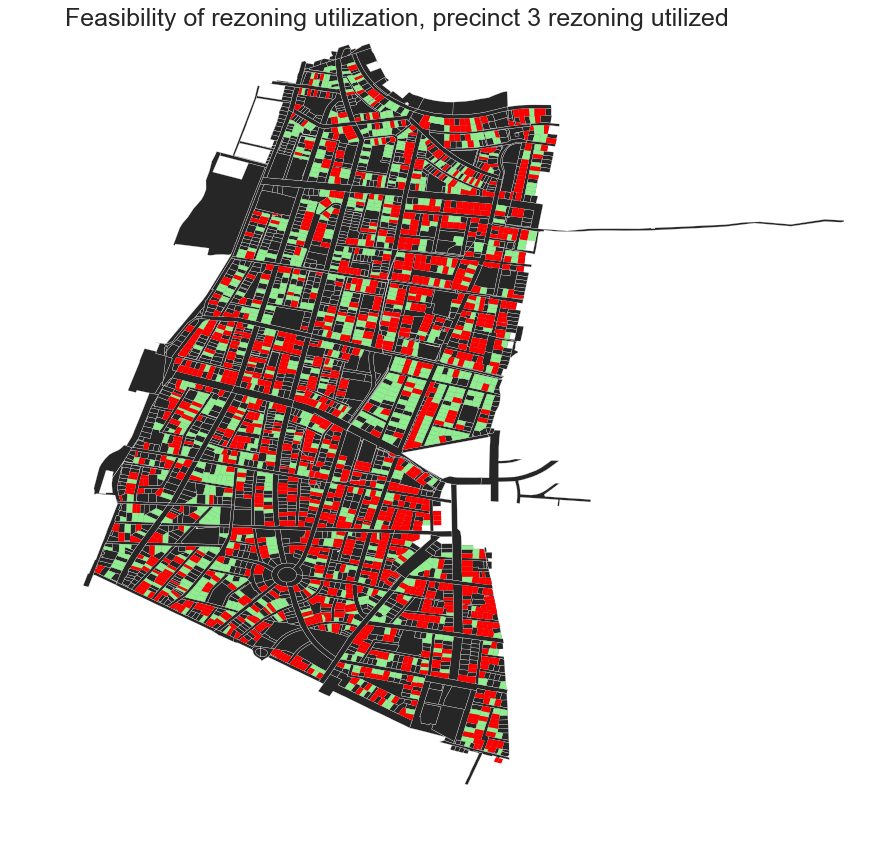

In [398]:
fig = pl.figure(figsize=(15,15))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
parcelsshp.plot(ax=ax, color='k', edgecolor='w',linewidth=.3, alpha=0.85)
PCT3shp[PCT3shp['Feasible'] == 0].plot(ax=ax, color='lightGreen', edgecolor=None)
PCT3shp[PCT3shp['Feasible'] == 1].plot(ax=ax, color='r', edgecolor=None)
plt.title('Feasibility of rezoning utilization, precinct 3 rezoning utilized', size=25, y=.97, x=0.42)
tmp = ax.axis('off')